# MCMC using backward filtering, forward guiding for shapes with SDE transitions

Parameter inference for trees with Brownian flows (Kunita flows) transitions along edges and observations at the leaf nodes for landmark represented shapes. Please refer to the notebooks [mcmc_Gaussian_BFFG.ipynb](mcmc_Gaussian_BFFG.ipynb), [mcmc_Gaussian_BFFG_shapes.ipynb](mcmc_Gaussian_BFFG_shapes.ipynb), [mcmc_Gaussian_BFFG_shapes_state-dependent_covariance.ipynb](mcmc_Gaussian_BFFG_shapes_state-dependent_covariance.ipynb) for simplified versions. The covariance of each stochastic step is shape dependent and the processes nonlinear, thus requiring computation of likelihood ratios in the downwards passes for use in the MCMC iterations.

The covariance is assumed rotationally invariant, allowing factorization into a kernel product the identity matrix of the ambient space.

The conditioning and upwards/downwards message passing and fusing operations follow the backward filtering, forward guiding approach of Frank van der Meulen, Moritz Schauer et al., see https://arxiv.org/abs/2010.03509 and https://arxiv.org/abs/2203.04155 . The latter reference provides an accesible introduction to the scheme and the notation used in this example.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey, split

from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda

from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree

from hyperiax.plotting import plot_tree_text, plot_shape_2d, plot_tree_2d_scatter, plot_tree_2d_shape

from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

from examples.SDE import dts, dot, solve, forward
from examples.ABFFG import *
from examples.shape import k_K2

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# seed,
seed = 42
#import os; seed = int(os.urandom(5).hex(), 16)
key = PRNGKey(seed)

# Shape related setup

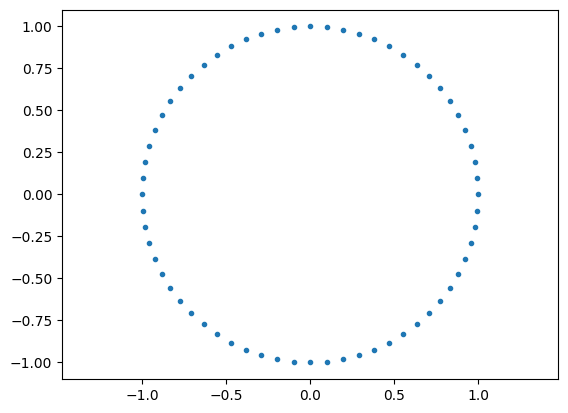

In [4]:
# define shape and plot
d = 2; n = 64 # d = dimension of embedding space (usually 2), n = number of landmarkds
phis = jnp.linspace(0,2*jnp.pi,n,endpoint=False) # circular shape
root = jnp.vstack((jnp.cos(phis),jnp.sin(phis))).T.flatten()

# plot
plot_shape = plot_shape_2d
plot_shape(root)

# SDE setup

In [5]:
n_steps = 100 # number of time steps in the discretization

 # drift
def b(t,x,params): return jnp.zeros(n*d)

# diffusion and covariance specification for shape processes
# assumes same covariance in all directions (x,y or x,y,z), thus allowing some factorization of the covariance matrix

kQ12 = lambda x,params: (1/n)*k_K2(x,params)

# evaluate k on two pairs of landmark configurations
kQ12_q = lambda q1,q2,params: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],params)

# diffusion field and covariance matrix factored in dimensions
sigma = lambda q,theta: kQ12_q(q,q,theta) # diffusion field, kernel evaluated on all landmark pairs
def a(q,theta): sigmaq = sigma(q,theta); return jnp.einsum('ij,kj->ik',sigmaq,sigmaq) # covariance

# Tree with SDE transitions

First, we initialize the tree. We set the root to the shape defined above.

In [6]:
# create topology and tree
topology = symmetric_topology(height=2, degree=5)
plot_tree_text(topology)
tree = HypTree(topology)
print(tree)

# add properties to tree
tree.add_property('edge_length', shape=())
# data dimension
d = 2
tree.add_property('value', shape=(n_steps+1,n*d,))
tree.add_property('noise', shape=(n_steps,n*d))

# set edge lengths on all nodes
tree.data['edge_length'] = jnp.ones_like(tree.data['edge_length'])

# root value
tree.data['value'] = tree.data['value'].at[0].set(root)

                                                            None
           ┌────────────────────────┬────────────────────────┼────────────────────────┬────────────────────────┐
          None                     None                     None                     None                     None          
 ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐  
None None None None None None None None None None None None None None None None None None None None None None None None None
HypTree(size=31, levels=3, leaves=25, inner nodes=5)


We then define parameters for the Gaussian transition kernel.

In [7]:
# parameters, variance and observation noise
params = ParameterStore({
    'k_alpha': VarianceParameter(.3), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.5), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3) # observation noise variance
    })

Now follows the down transitions using the SDE functions above. The step covariance is square of the pairwise kernel evaluations in `sigma(params)` times the variance parameter times edge lengths.

In [8]:
# vmapped version of down_unconditional. In this version, the function takes a single node, not a batch (contrast to the batched version in mcmc_Gaussian_BFFG.ipynb)
@jax.jit
def down_unconditional(noise,edge_length,parent_value,params,**args):
    def f(noise,edge_length,parent_value):
        var = edge_length # variance is edge length
        _dts = dts(T=var,n_steps=n_steps); _dWs = jnp.sqrt(_dts)[:,None]*noise
        Xs = forward(parent_value.reshape((-1,n*d))[-1],_dts,_dWs,b,sigma,params)
        return {'value': Xs}

    return jax.vmap(f)(noise,edge_length,parent_value)
downmodel_unconditional = DownLambda(down_fn=down_unconditional)
down_unconditional = OrderedExecutor(downmodel_unconditional)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. Note that observation noise is not added to the leaves yet.

In [9]:
# sample new noise
def update_noise(tree,key): 
    tree.data['noise'] = jax.random.normal(key, shape=tree.data['noise'].shape)

subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())

Add uncorrelated observation noise to leaves.



In [10]:
# add noise to leaf nodes
key, subkey = split(key)
trajectories = tree.data['value'][tree.is_leaf]
trajectories = trajectories.at[:,-1].add(jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,trajectories[:,-1].shape))
leaf_values = trajectories[:,-1]
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(trajectories)

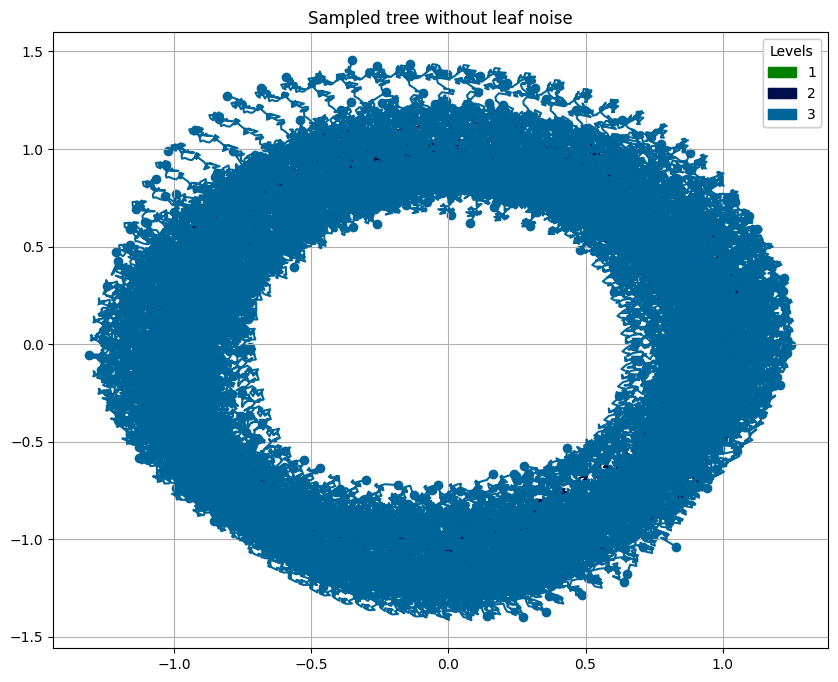

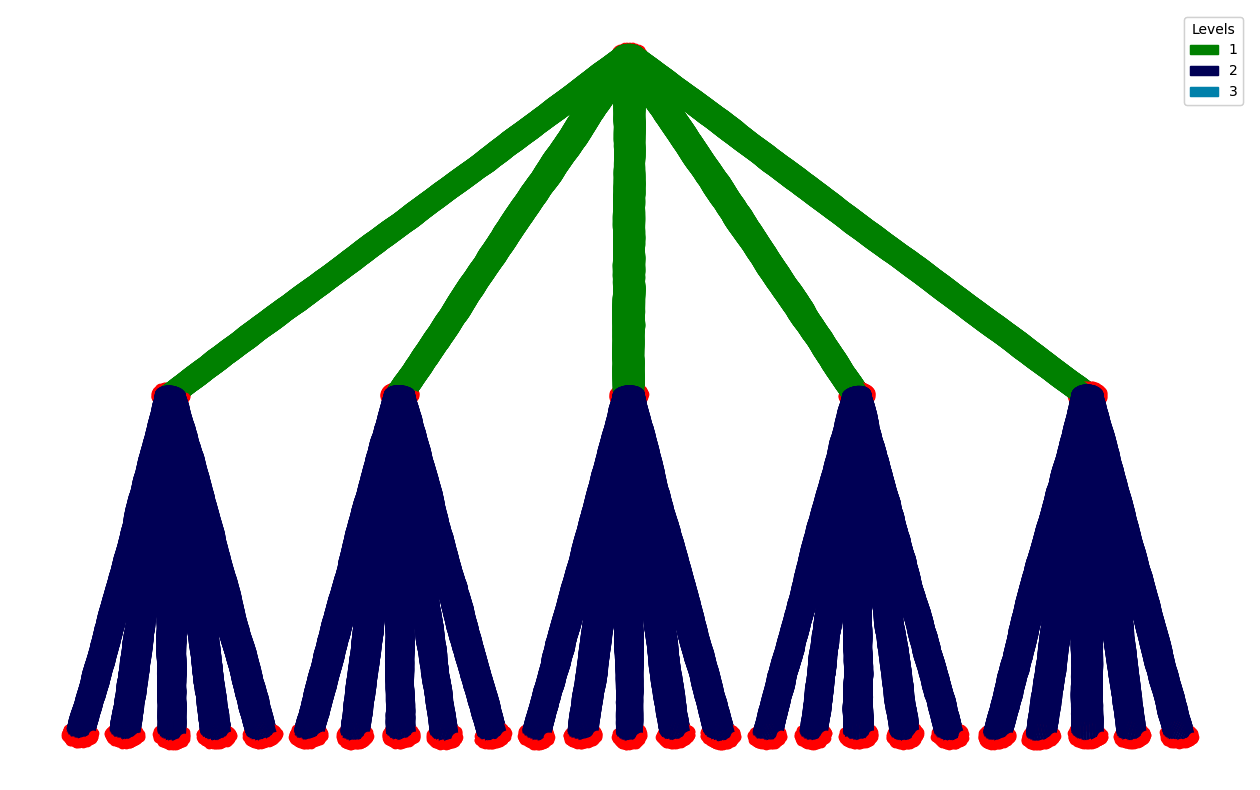

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
plot_tree_2d_scatter(tree,'value',selector=lambda z: z.reshape((-1,n,d)),ax=ax)
plt.gca().set_title('Sampled tree without leaf noise')

plot_tree_2d_shape(tree,'value')

# Backwards filtering, forward guiding

We now define the backwards filter through the up function. The Gaussian are parametrized in the $(c,F,H)$ format make the fuse just a sum of the results of the up operation. See https://arxiv.org/abs/2203.04155 for details.

In [12]:
# backwards filter
@jax.jit
def up(noise,edge_length,F_T,H_T,tildea,params,**args):
    def f(edge_length,F_T,H_T,tildea):
        var = edge_length # variance is edge length
        T = var # running time of Brownian motion

        _ts = jnp.cumsum(jnp.concatenate((jnp.array([0.]), dts(T=T,n_steps=n_steps))))[:-1]
        Phi_inv = lambda t:  jnp.eye(n)+H_T@tildea*(T-t)
        H_0 = solve(Phi_inv(0),H_T).reshape(H_T.shape)
        F_0 = solve(Phi_inv(0),F_T).reshape(F_T.shape)
        v_T = solve(H_T,F_T)
        
        c_0 = jax.vmap(lambda v_T: logphi_H(jnp.zeros(n),v_T,H_0),1)(v_T.reshape((n,d)))
        return {'c_0': c_0, 'F_0': F_0, 'H_0': H_0}
    return jax.vmap(f)(edge_length,F_T,H_T,tildea)
def transform(child_c_0,child_F_0,child_H_0,params,**args):
    F_T = child_F_0
    H_T = child_H_0
    c_T = child_c_0
    v_T = jax.vmap(lambda H,F: solve(H,F))(H_T,F_T)
    tildea = jax.vmap(lambda v: a(v,params))(v_T)
    return {'c_T': c_T, 'F_T': F_T, 'H_T': H_T, 'tildea': tildea}
upmodel = UpLambdaReducer(up, transform,
                   reductions={
                       'c_0': 'sum',
                       'F_0': 'sum',
                       'H_0': 'sum',
                    }
        )
up = OrderedExecutor(upmodel)

We initialize the tree for up by computing the $c,F,H$-values at the leaves.

In [13]:
# initialize tree for up
tree.add_property('c_0', shape=(d,)); tree.add_property('F_0', shape=(n*d,)); tree.add_property('H_0', shape=(n,n)); tree.add_property('c_T', shape=(d,)); tree.add_property('F_T', shape=(n*d,)); tree.add_property('H_T', shape=(n,n)); tree.add_property('logpsi'); tree.add_property('tildea', shape=(n,n))
def init_up(leaf_values,params):
    tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(tree.data['value'][tree.is_leaf].at[:,-1].set(leaf_values))
    tree.data['H_T'] = tree.data['H_T'].at[tree.is_leaf].set((jnp.eye(n)/params['obs_var'].value)[None,:,:])
    tree.data['F_T'] = tree.data['F_T'].at[tree.is_leaf].set(jax.vmap(lambda H,v: dot(H,v))(tree.data['H_T'][tree.is_leaf],leaf_values))
    Sigma = params['obs_var'].value*jnp.eye(n)
    tree.data['c_T'] = tree.data['c_T'].at[tree.is_leaf].set(jax.vmap(lambda v: jax.vmap(lambda v: logphi(jnp.zeros(n),v,Sigma),1)(v.reshape((n,d))))(leaf_values))
    tree.data['tildea'] = tree.data['tildea'].at[tree.is_leaf].set(jax.vmap(lambda v: a(v,params.values()))(leaf_values))


We can now define the conditional downwards pass, i.e. the forwards guiding.

In [14]:
@jax.jit
def down_conditional(noise,edge_length,F_T,H_T,tildea,parent_value,params,**args):
    def f(noise,edge_length,F_T,H_T,tildea,parent_value):
        var = edge_length # variance is edge length
        _dts = dts(T=var,n_steps=n_steps)
        _dWs = jnp.sqrt(_dts)[:,None]*noise
        Xs,logpsi = forward_guided(parent_value.reshape((-1,n*d))[-1],H_T,F_T,tildea,_dts,_dWs,b,sigma,params)
        return {'value': Xs, 'logpsi': logpsi}

    return jax.vmap(f)(noise,edge_length,F_T,H_T,tildea,parent_value)
downmodel_conditional = DownLambda(down_fn=down_conditional)
down_conditional = OrderedExecutor(downmodel_conditional)

We make an upwards pass and a downwards conditional sampling to test. Subsequently, we time the three operations (uncondtional down, conditional down, and up).

In [15]:
# backwards filter and fowards guiding
init_up(leaf_values,params)
up.up(tree,params.values())
down_conditional.down(tree,params.values())

# time the operations
subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())
%time down_unconditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time down_conditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time up.up(tree,params.values()); jax.block_until_ready(tree.data['H_0'])
None

CPU times: user 628 ms, sys: 45.1 ms, total: 673 ms
Wall time: 547 ms
CPU times: user 661 ms, sys: 39.7 ms, total: 701 ms
Wall time: 590 ms
CPU times: user 11.6 ms, sys: 1.79 ms, total: 13.4 ms
Wall time: 10.3 ms


# MCMC

MCMC run incorporating the likelihood ratios arising from the Gaussian approximation.

Initial parameters:  {'k_alpha': 0.25, 'k_sigma': 0.45, 'obs_var': 0.001}
data parameters:  {'k_alpha': 0.3, 'k_sigma': 0.5, 'obs_var': 0.001}


100%|██████████| 200/200 [02:13<00:00,  1.50it/s]

Acceptance rate: 0.2600


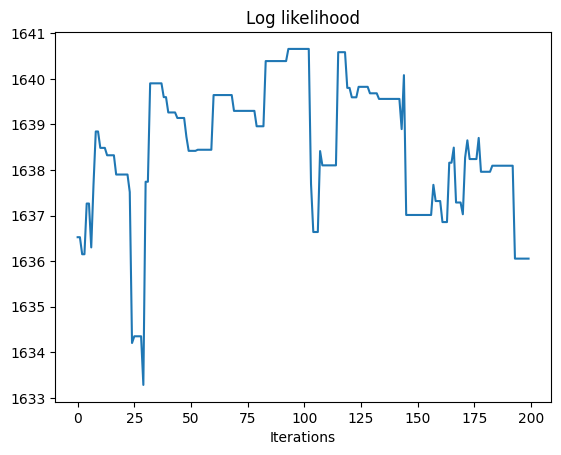

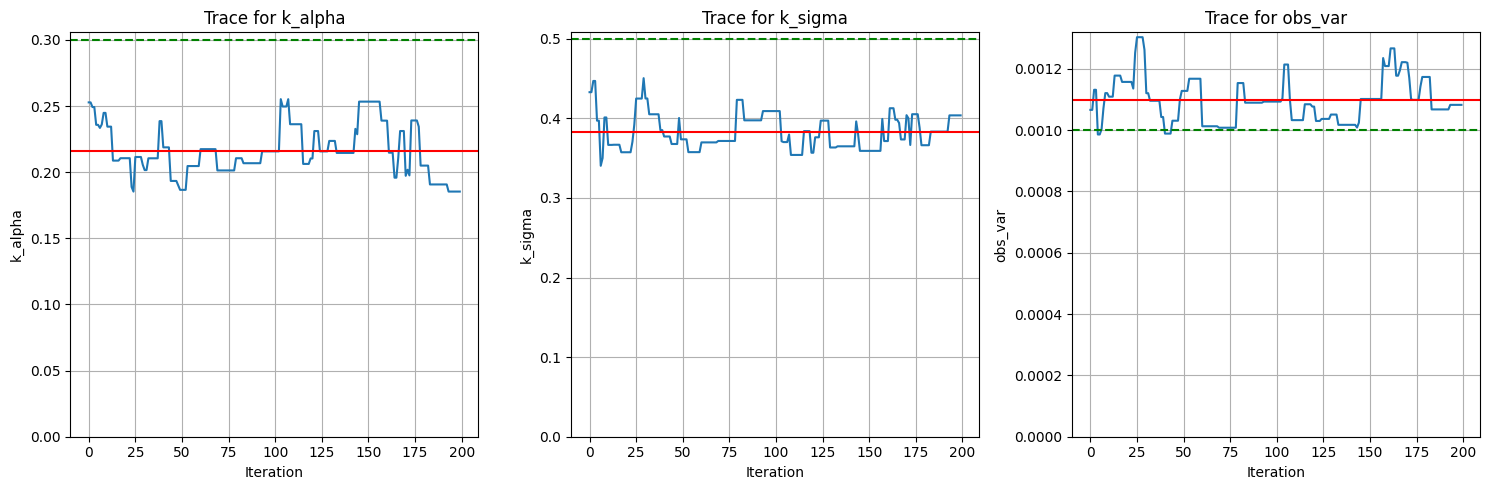

In [16]:
# inference for Gaussian model, likelihood from forward guiding

# Crank-Nicolson update with possibly node-dependent lambd
lambd = .9
update_CN = lambda noise,key: noise*lambd+jnp.sqrt((1-lambd**2))*jax.random.normal(key,noise.shape)

# log likelihood of the tree under the Gaussian approximation with correction factors
def log_likelihood(data,state):
    """Log likelihood of the tree."""
    params,noise = state
    # backwards filtering with current parameters
    init_up(data,params); up.up(tree,params.values())
    # forwards guiding with current noise
    tree.data['noise'] = noise; down_conditional.down(tree,params.values())
    v,c,F,H = tree.data['value'][tree.is_root][:,0],tree.data['c_T'][tree.is_root],tree.data['F_T'][tree.is_root],tree.data['H_T'][tree.is_root]
    v = jnp.squeeze(v); c = jnp.squeeze(c); F = jnp.squeeze(F); H = jnp.squeeze(H)
    tree_log_likelihood = c.sum()+F@v-.5*v.T@dot(H,v)
    tree_logpsi = jnp.mean(tree.data['logpsi'][1:])
    residuals = tree.data['value'][tree.is_leaf][:,-1]-data
    leaves_log_likelihood = jnp.mean(jax.scipy.stats.norm.logpdf(residuals,0,jnp.sqrt(params['obs_var'].value)))
    return tree_log_likelihood+tree_logpsi+leaves_log_likelihood

def log_posterior(data,state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(data,state)
    return log_prior + log_like

def proposal(data, state, key):
    subkeys = jax.random.split(key,2)
    parameters,noise = state

    # update parameters
    new_parameters = parameters.propose(subkeys[0])
    # update noise
    new_noise = update_CN(noise,subkeys[1])

    return new_parameters,new_noise

# tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.25,alpha=3,beta=.5), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.45,alpha=2,beta=.5), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3,alpha=2,beta=.003) # observation noise varianc
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
init_state = (init_params,jnp.zeros_like(tree.data['noise']))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_values, init_state, 200, burn_in=00, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples,params.values())